In [4]:
# ============================================================
# MNIST → PCA → Échantillonage stratifié → OvA Logistic Regression
# ============================================================

import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix

print("Chargement MNIST...")
mnist = fetch_openml('mnist_784', version=1)
X, y = mnist["data"], mnist["target"].astype(np.uint8)

# ------------------------------------------------------------
# 1) Split standard MNIST 60k / 10k
# ------------------------------------------------------------
X_train, X_test = X[:60000], X[60000:]
y_train, y_test = y[:60000], y[60000:]

print("MNIST chargé.")

# ------------------------------------------------------------
# 2) PCA sur TOUT le train (réduction de dimension)
# ------------------------------------------------------------
print("PCA en cours...")
pca = PCA(n_components=100)
X_train_reduced = pca.fit_transform(X_train)
X_test_reduced  = pca.transform(X_test)
print("PCA terminé.")

# ------------------------------------------------------------
# 3) Échantillonnage stratifié après PCA
# ------------------------------------------------------------
print("Échantillonnage stratifié...")
X_small, _, y_small, _ = train_test_split(
    X_train_reduced,
    y_train,
    train_size=0.2,     # ~12 000 images sur les 60k
    stratify=y_train,
    random_state=42
)
print("Taille de l'échantillon :", X_small.shape)

# ------------------------------------------------------------
# 4) Entraînement OvA Logistic Regression
# ------------------------------------------------------------
print("Entraînement des 10 classifieurs One-vs-All...")
ova_clfs = []

for k in range(10):
    print(f" → Classe {k} en cours...")
    y_k = (y_small == k).astype(int)

    clf = LogisticRegression(
        solver="saga",
        max_iter=6000,
        n_jobs=-1
    )
    clf.fit(X_small, y_k)
    ova_clfs.append(clf)

print("Entraînement OvA terminé.")



Chargement MNIST...
MNIST chargé.
PCA en cours...
PCA terminé.
Échantillonnage stratifié...
Taille de l'échantillon : (12000, 100)
Entraînement des 10 classifieurs One-vs-All...
 → Classe 0 en cours...
 → Classe 1 en cours...
 → Classe 2 en cours...
 → Classe 3 en cours...
 → Classe 4 en cours...
 → Classe 5 en cours...
 → Classe 6 en cours...
 → Classe 7 en cours...
 → Classe 8 en cours...
 → Classe 9 en cours...
Entraînement OvA terminé.


In [5]:
import numpy as np

def predict_ova(X_reduced, ova_clfs):
    # Pour chaque classifieur, on récupère la probabilité "classe = 1"
    probas = np.column_stack([
        clf.predict_proba(X_reduced)[:, 1]    # colonne proba d'être dans la classe k
        for clf in ova_clfs
    ])

    # On prend la classe avec la proba maximale
    predictions = np.argmax(probas, axis=1)
    return predictions

In [6]:
y_test_pred = predict_ova(X_test_reduced, ova_clfs)

from sklearn.metrics import accuracy_score, confusion_matrix

acc = accuracy_score(y_test, y_test_pred)
cm = confusion_matrix(y_test, y_test_pred)

print("Accuracy :", acc)
print("Matrice de confusion :\n", cm)


Accuracy : 0.861
Matrice de confusion :
 [[ 952    0    0    1    1    5   15    1    5    0]
 [   0 1106    2    1    2    2    5    1   16    0]
 [  28   66  821   18   12    1   18   31   31    6]
 [  10   27   23  865    5   13   11   31   19    6]
 [   1   24    6    1  885    1   13    3    9   39]
 [  36   20    5   78   31  612   38   26   37    9]
 [  28   13    4    0   11    9  891    0    2    0]
 [   6   39   16    5   15    0    3  914    0   30]
 [  22   67    6   30   22   18   28   15  754   12]
 [  27   16    2   14   65    4    5   62    4  810]]


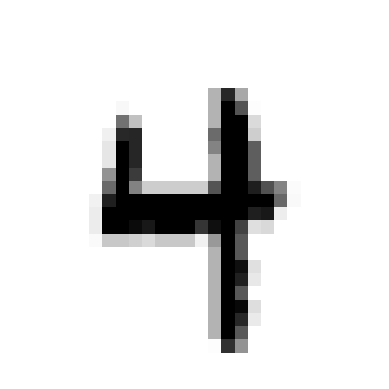

Prédiction : 4  — True label : 4


In [7]:
i = 1599

# récupérer les pixels
un_chiffre = X_test.iloc[i].to_numpy()

# remettre en forme 28×28
un_chiffre_image = un_chiffre.reshape(28, 28)

# affichage
import matplotlib.pyplot as plt
plt.imshow(un_chiffre_image, cmap="binary")
plt.axis("off")
plt.show()

x = X_test_reduced[i].reshape(1, -1)
pred = np.argmax([clf.predict_proba(x)[0, 1] for clf in ova_clfs])

print("Prédiction :", pred, " — True label :", y_test.iloc[i])

Nombre d'erreurs : 1390


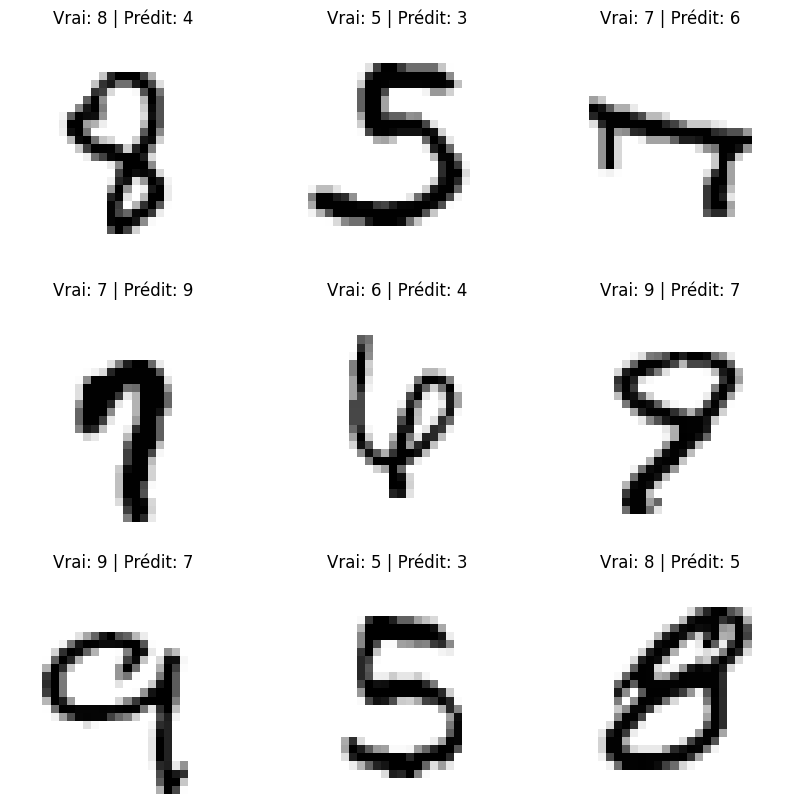

In [8]:
# Indices des prédictions incorrectes
incorrect_indices = np.where(y_test_pred != y_test)[0]
print("Nombre d'erreurs :", len(incorrect_indices))


import random
import matplotlib.pyplot as plt

def show_errors(n=9):
    # choisir n erreurs au hasard
    sample = random.sample(list(incorrect_indices), n)

    plt.figure(figsize=(10, 10))

    for idx, img_idx in enumerate(sample):
        plt.subplot(3, 3, idx + 1)

        image = X_test.iloc[img_idx].to_numpy().reshape(28, 28)
        true = y_test.iloc[img_idx]
        pred = y_test_pred[img_idx]

        plt.imshow(image, cmap="binary")
        plt.title(f"Vrai: {true} | Prédit: {pred}")
        plt.axis("off")

    plt.show()

# Afficher les erreurs
show_errors()


In [9]:
# ============================================================
# 6) 45 Classifieurs One-vs-One (OvO)
# ============================================================

ovo_clfs = {}   # dictionnaire : clé = (i,j), valeur = modèle entraîné

print("\nEntraînement des 45 classifieurs One-vs-One...")

for i in range(10):
    for j in range(i + 1, 10):
        # données contenant seulement les classes i et j
        mask = (y_small == i) | (y_small == j)
        X_ij = X_small[mask]
        y_ij = y_small[mask]

        clf = LogisticRegression(
            solver="saga",
            max_iter=6000,
            n_jobs=-1
        )

        print(f" → Classe {i} vs {j}")
        clf.fit(X_ij, y_ij)

        ovo_clfs[(i, j)] = clf



Entraînement des 45 classifieurs One-vs-One...
 → Classe 0 vs 1
 → Classe 0 vs 2
 → Classe 0 vs 3
 → Classe 0 vs 4
 → Classe 0 vs 5
 → Classe 0 vs 6
 → Classe 0 vs 7
 → Classe 0 vs 8
 → Classe 0 vs 9
 → Classe 1 vs 2
 → Classe 1 vs 3
 → Classe 1 vs 4
 → Classe 1 vs 5
 → Classe 1 vs 6
 → Classe 1 vs 7
 → Classe 1 vs 8
 → Classe 1 vs 9
 → Classe 2 vs 3
 → Classe 2 vs 4
 → Classe 2 vs 5
 → Classe 2 vs 6
 → Classe 2 vs 7
 → Classe 2 vs 8
 → Classe 2 vs 9
 → Classe 3 vs 4
 → Classe 3 vs 5
 → Classe 3 vs 6
 → Classe 3 vs 7
 → Classe 3 vs 8
 → Classe 3 vs 9
 → Classe 4 vs 5
 → Classe 4 vs 6
 → Classe 4 vs 7
 → Classe 4 vs 8
 → Classe 4 vs 9
 → Classe 5 vs 6
 → Classe 5 vs 7
 → Classe 5 vs 8
 → Classe 5 vs 9
 → Classe 6 vs 7
 → Classe 6 vs 8
 → Classe 6 vs 9
 → Classe 7 vs 8
 → Classe 7 vs 9
 → Classe 8 vs 9


In [10]:
def predict_combined_one(x):
    # Probabilités OvA pour chaque classe
    ova_proba = np.array([clf.predict_proba(x)[0, 1] for clf in ova_clfs])

    # Classes reconnues par OvA (seuil 0.5)
    winners = np.where(ova_proba > 0.5)[0]

    # 1) Aucun OvA ne reconnaît l'image → prendre max proba
    if len(winners) == 0:
        return np.argmax(ova_proba)

    # 2) Une seule classe gagnante OvA → pas de conflit
    if len(winners) == 1:
        return winners[0]

    # 3) Conflit OvA → Votes OvO entre les gagnants
    votes = {c: 0 for c in winners}

    for i in range(len(winners)):
        for j in range(i + 1, len(winners)):
            a, b = winners[i], winners[j]
            key = (min(a, b), max(a, b))

            pred = ovo_clfs[key].predict(x)[0]
            votes[pred] += 1

    # 4) Classe ayant le plus de votes
    max_votes = max(votes.values())
    tied = [c for c, v in votes.items() if v == max_votes]

    # 5) Pas d'égalité → gagnant clair
    if len(tied) == 1:
        return tied[0]

    # 6) Cycle ou égalité → choisir celui avec plus grande probabilité OvA
    return max(tied, key=lambda c: ova_proba[c])


In [11]:
def predict_combined(X_reduced):
    preds = []
    for i in range(X_reduced.shape[0]):
        x = X_reduced[i].reshape(1, -1)
        preds.append(predict_combined_one(x))
    return np.array(preds)


In [12]:
print("\nÉvaluation du modèle combiné OvA + OvO...")

y_test_pred_combined = predict_combined(X_test_reduced)

acc_combined = accuracy_score(y_test, y_test_pred_combined)
cm_combined = confusion_matrix(y_test, y_test_pred_combined)

print("Accuracy combinée :", acc_combined)
print("Matrice de confusion combinée :\n", cm_combined)



Évaluation du modèle combiné OvA + OvO...
Accuracy combinée : 0.8829
Matrice de confusion combinée :
 [[ 948    0    4    3    1    5   11    2    6    0]
 [   0 1103    2    1    2    1    5    1   20    0]
 [  18   37  869   16   15    1   13   28   30    5]
 [   9   18   23  882    4   17    7   23   20    7]
 [   2    8    6    1  898    1   15    3    8   40]
 [  29   12    3   62   25  672   30   16   38    5]
 [  19    9    8    0    9    7  905    1    0    0]
 [   3   31   19    9    7    0    3  933    4   19]
 [  19   51    7   25   17   18   23   13  791   10]
 [  24   13    3   13   63    4    5   50    6  828]]
